In [1]:
import pandas as pd

# Read data
df = pd.read_excel("MyFoodData.xlsx")

# Drops unrelevant columns
df = df.filter(items = ["Name", "Calories", "Protein (g)"])
df.head()

,Name,Calories,Protein (g)
0,Pillsbury Golden Layer Buttermilk Biscuits Art...,307.0,5.88
1,Pillsbury Cinnamon Rolls With Icing Refrigerat...,330.0,4.34
2,Kraft Foods Shake N Bake Original Recipe Coati...,377.0,6.10
3,George Weston Bakeries Thomas English Muffins,232.0,8.00
4,Waffles Buttermilk Frozen Ready-To-Heat,273.0,6.58


In [2]:
def calculateFitness(chromosome: list, maxWeight: int, negative: bool, penaltyFactor: float = 1.5):
    totalValue = 0
    totalWeight = 0

    for i in range(len(chromosome)):
        if chromosome[i] == 1:
            value = df.iloc[i]['Protein (g)']
            totalValue += value
            
            weight = df.iloc[i]['Calories']
            totalWeight += weight
    
    proteinWeight = 10
    # Penalty if the weight exceeds maxWeight
    if totalWeight > maxWeight:
        penalty = (totalWeight - maxWeight) ** penaltyFactor
        fitness = proteinWeight * totalValue - penalty
    # No penalty
    else:
        fitness = proteinWeight * totalValue

    if (negative):
        finalFitness = fitness
    else:
        return max(1, fitness)
        
    return finalFitness

In [3]:
import random

def generateIndividualWithLimit(chromosomeSize: int, maxCalories: int):
    chromosome = [0] * chromosomeSize
    indices = list(range(chromosomeSize))
    random.shuffle(indices)

    totalCalories = 0
    for i in indices:
        calorie = df.iloc[i]['Calories']
        if totalCalories + calorie <= maxCalories:
            chromosome[i] = 1
            totalCalories += calorie
        else:
            break
    return chromosome


In [4]:
import random 

def initializePopulation(populationSize: int, chromosomeSize: int, seed: int = None):
    population = []

    # Set seed
    if seed is not None:
        random.seed(seed)

    # Randomly generate populationSize amount of chromosomes with chromosomeSize size
    for i in range(populationSize):
        member = [random.randint(0, 1) for i in range(chromosomeSize)]
        population.append(member)
    
    random.seed(None)
    
    return population

def initializePopulationWithMaxWeight(populationSize: int, chromosomeSize: int, maxCalories: int, seed: int = None, rate: float = 1):
    population = []

    # Set seed
    if seed is not None:
        random.seed(seed)

    # Randomly generate populationSize amount of chromosomes with chromosomeSize size
    for i in range(int(populationSize * rate)):
        member = [random.randint(0, 1) for i in range(chromosomeSize)]
        population.append(member)
    
    while len(population) != populationSize:
        member = generateIndividualWithLimit(chromosomeSize, maxCalories)
        population.append(member)
        
    random.seed(None)
    
    return population



In [5]:
def sortPopulation(population: list[list], maxWeight: int, negative: bool, penaltyFactor: float = 1.5):
    return sorted(population, key=lambda individual: calculateFitness(individual, maxWeight, negative, penaltyFactor), reverse=True)


In [6]:
def rouletteWheelSelection(population: list[list], maxWeight: int, penaltyFactor: float = 1.5):
    total_fitness = 0
    fitnesses = []

    # Add all fitnesses
    for i in population:
        # Negative fitness is not allowed
        fitness = calculateFitness(i, maxWeight, False, penaltyFactor)
        fitnesses.append(fitness)
        total_fitness += fitness

    # An individual in the population have fitness / (sum of all fitnesses) chance to be selected in the Roulette Wheel Selection
    prob_sum = 0
    # Random float as roulette
    roulette = random.uniform(0, total_fitness)
    for i in range(len(population)):
        # If the prob_sum + fitness of the individual exceedes the roulette value, the roulette is in that probability area, so the individual is selected
        # Example:
        # If we have 5 individuals with fitness values 5, 10, 15, 6, 3 and roulette as 21, the individual with fitness value 15 should be selected.
        # In the first iteration of the loop prob_sum would be 5, in the second iteration 15 and in the third iteration it would be 30, exceeding the roulette value
        # Third individual from the population would be selected according to this algorithm
        prob_sum += fitnesses[i]
        if prob_sum > roulette:
            return population[i]

        

In [7]:
import sys

def tournamentSelection(population: list[list], tournamentSize: int, maxWeight: int, penaltyFactor: float = 1.5):
    # tournamentSize amount of individuals are selected for the tournament
    randomIndividuals = random.sample(range(0, len(population)), tournamentSize)
    bestFitness = -sys.maxsize - 1
    bestIndividual = -1
    #print(randomIndividuals)
    
    for i in randomIndividuals:
        # Individual with best fitness wins the tournament
        # This individual is selected
        fitness = calculateFitness(population[i], maxWeight, True, penaltyFactor)
        #print(f"Individual {i}, fitness {fitness}")
        if fitness > bestFitness:
            bestFitness = fitness
            bestIndividual = i
    return population[bestIndividual]


In [8]:
population = initializePopulation(10, 5)

bestIndividual = tournamentSelection(population, 4, 2500)
print(bestIndividual)

[1, 1, 0, 1, 1]


In [9]:
import random

def singlePointCrossover(firstParent: list, secondParent: list):

   # Selects a random crossover point
   crossOverPoint = random.randint(1, len(firstParent) - 1)

   # Selects the crossover parts from parents (From random point to end of the chromosome)
   crossOverPart1 = firstParent[crossOverPoint: len(firstParent)]
   crossOverPart2 = secondParent[crossOverPoint: len(secondParent)]

   firstOffspring = firstParent
   secondOffspring = secondParent

   # Swaps the crossover parts between parents
   firstOffspring[crossOverPoint: len(firstParent)] = crossOverPart2
   secondOffspring[crossOverPoint: len(secondParent)] = crossOverPart1

   return [firstOffspring, secondOffspring]

In [10]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = singlePointCrossover(firstParent, secondParent)
print(offsprings)

[[0, 1, 0, 0, 0, 1], [1, 0, 1, 1, 0, 1]]


In [11]:
def multiplePointCrossover(firstParent: list, secondParent: list):
    # Selects two random crossover points
    firstCrossOverPoint = random.randint(1, len(firstParent) - 1)
    secondCrossOverPoint = random.randint(1, len(secondParent) - 1)

    # Change the crossover point if the points are same
    while (firstCrossOverPoint == secondCrossOverPoint):
        secondCrossOverPoint = random.randint(1, len(firstParent) - 1)
    
    # If the first crossover point is at the right of the second crossover point swap the points
    if (firstCrossOverPoint > secondCrossOverPoint):
        firstCrossOverPoint, secondCrossOverPoint = secondCrossOverPoint, firstCrossOverPoint
    
    # Select the crossover parts from point1 to point2
    crossOverPart1 = firstParent[firstCrossOverPoint: secondCrossOverPoint + 1]
    crossOverPart2 = secondParent[firstCrossOverPoint: secondCrossOverPoint + 1]

    firstOffspring = firstParent
    secondOffspring = secondParent

    # Swap the crossover parts between parents
    firstOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart2
    secondOffspring[firstCrossOverPoint: secondCrossOverPoint + 1] = crossOverPart1

    return [firstOffspring, secondOffspring]

    


In [12]:
def uniformCrossover(firstParent: list, secondParent: list, maxWeight: int, penaltyFactor: float = 1.5):
    firstFitness = calculateFitness(firstParent, maxWeight, True, penaltyFactor)
    secondFitness = calculateFitness(secondParent, maxWeight, True, penaltyFactor)

    minFitness = min(firstFitness, secondFitness)
    if minFitness <= 0:
        shift = abs(minFitness) + 1
        firstFitness += shift
        secondFitness += shift

    if (firstFitness == 0 and secondFitness == 0):
        probability = 0.5
    else:
        # Probability in the uniform crossover is fp_1 / (fp_1 + fp_2), where fp_1 is the fitness of the first parent and fp_2 is the fitness of the second parent
        probability = firstFitness / (firstFitness + secondFitness)
    
    firstOffspring = []
    secondOffspring = []
    i = 0
    length = len(firstParent)
    while (len(firstOffspring) != length):
        randomProb = random.random()
        # First chromosome have the chance fp_1 / (fp_1 + fp_2) to the get the gene from first parent.
        # If the probability is higher than the random value, first offspring gets the gene from first parent
        # This repeats for all of the genes (length of the chromosome)
        if (randomProb < probability):
            firstOffspring.append(firstParent[i])
            secondOffspring.append(secondParent[i])
        else:
            firstOffspring.append(secondParent[i])
            secondOffspring.append(firstParent[i])
        i += 1

    return [firstOffspring, secondOffspring]



In [13]:
import random

def performCrossover(firstParent: list, secondParent: list, crossoverType: str, crossoverRate: float, maxWeight: int, penaltyFactor: float = 1.5):
    randomProb = random.random()
    if not (randomProb < crossoverRate):
        return [firstParent, secondParent]
    if crossoverRate == "single":
        return singlePointCrossover(firstParent, secondParent)
    elif crossoverRate == "multiple":
        return multiplePointCrossover(firstParent, secondParent)
    else:
        return uniformCrossover(firstParent, secondParent, maxWeight, penaltyFactor)

In [14]:
firstParent = [0, 0 , 1, 1, 0, 1]
secondParent = [1, 1, 0, 0, 0, 1]

offsprings = uniformCrossover(firstParent, secondParent, 1000)
print(offsprings)

[[1, 1, 1, 0, 0, 1], [0, 0, 0, 1, 0, 1]]


In [15]:
def mutation(chromosome: list, rate: int):
    mutationsRate = 1 / rate
    for i in range(len(chromosome)):
        # random.random() generates a float between 0 and 1
        # If this number is less than or equal to mutation rate there is a bit flip in that gene (mutation occurs)
        if random.random() <= mutationsRate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

In [16]:
chromosome = [0, 0, 1, 1, 1, 0, 1]
print(mutation(chromosome, 10))

[0, 1, 0, 1, 1, 0, 1]


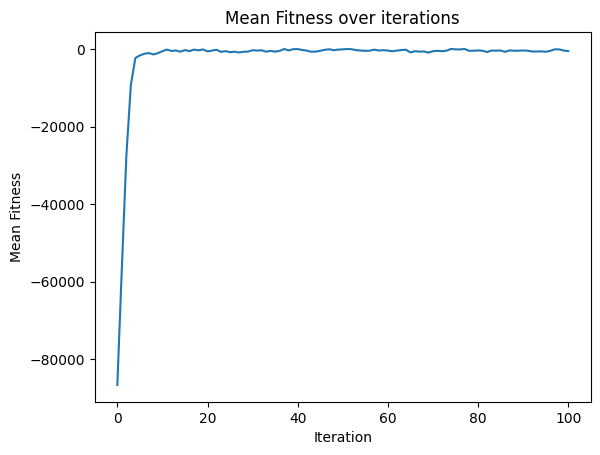

In [21]:
import numpy as np
import matplotlib.pyplot as plt

populationSize = 100
chromosomeSize = 100
seed = 42
maxWeight = 2000
#population = initializePopulation(populationSize, chromosomeSize, seed)
population = initializePopulationWithMaxWeight(populationSize, chromosomeSize, maxWeight, seed, 0.75)

def geneticAlgorithm(population: list[list], 
                     maxWeight: int, 
                     generations: int, 
                     crossoverRate: float, 
                     crossoverType: str, 
                     elitSize: int, 
                     penaltyFactor: float = 1.5):
    
    meanFitness = []
    fitnessList = [calculateFitness(i, maxWeight, True, penaltyFactor) for i in population]
    mean = np.mean(fitnessList)
    meanFitness.append(mean)
    

    for i in range(generations):
        sortedPopulation = sortPopulation(population, maxWeight, True, penaltyFactor)
        new_population = sortedPopulation[:elitSize]
        while len(new_population) != len(population):
            
            firstIndividual = tournamentSelection(population, 2, maxWeight, penaltyFactor)
            secondIndividual = tournamentSelection(population, 2, maxWeight, penaltyFactor)
        
            #firstIndividual = rouletteWheelSelection(population, maxWeight, penaltyFactor)
            #secondIndividual = rouletteWheelSelection(population, maxWeight, penaltyFactor)
            
            #offsprings = singlePointCrossover(firstIndividual, secondIndividual)
            offsprings = performCrossover(firstIndividual, secondIndividual, crossoverType, crossoverRate, maxWeight, penaltyFactor)
            #offsprings = multiplePointCrossover(firstIndividual, secondIndividual)
            offsprings[0] = mutation(offsprings[0], len(offsprings[0]))
            offsprings[1] = mutation(offsprings[1], len(offsprings[1]))

            new_population.extend(offsprings)

        population = new_population
        #print(f"Generation {i}")
        #print(population)
        
        fitnessList = [calculateFitness(i, maxWeight, True, penaltyFactor) for i in population]
        mean = np.mean(fitnessList)
        meanFitness.append(mean)
        
    x = np.arange(0, generations + 1)
    plt.plot(x, meanFitness)
    plt.title("Mean Fitness over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Fitness")
    
    return population

generations = 100
elitismSize = 2
penaltyFactor = 1.2
crossoverRate = 1
crossoverType = "uniform"
new = geneticAlgorithm(population, maxWeight, generations,crossoverRate, crossoverType, elitismSize, penaltyFactor)


In [22]:
sortedNew = sortPopulation(new, maxWeight, True, penaltyFactor)

for i in sortedNew:
    fitness = calculateFitness(i, maxWeight, True, penaltyFactor)
    totalWeight = 0
    totalProtein = 0
    
    for j in range(len(i)):
        if i[j]:  
            protein = df.iloc[j]['Protein (g)']
            weight = df.iloc[j]['Calories']
            totalProtein += protein
            totalWeight += weight

    print(f"Fitness {fitness}, calorie {totalWeight}, protein {totalProtein}")


print(sortedNew[0])
for i, value in enumerate(sortedNew[0]):
    if value == 1:
        print(f"Name: {df.iloc[i]['Name']}, Protein (g): {df.iloc[i]['Protein (g)']}, Calories: {df.iloc[i]['Calories']}")

Fitness 1575.2999999999997, calorie 1969.0, protein 157.52999999999997
Fitness 1575.2999999999997, calorie 1969.0, protein 157.52999999999997
Fitness 1527.6, calorie 1910.0, protein 152.76
Fitness 1460.162320580974, calorie 2019.0, protein 149.43999999999997
Fitness 1460.162320580974, calorie 2019.0, protein 149.43999999999997
Fitness 1450.7402140868505, calorie 2017.0, protein 148.07
Fitness 1443.6825852003437, calorie 2049.0, protein 155.04
Fitness 1440.6999999999998, calorie 1856.0, protein 144.07
Fitness 1407.0, calorie 1991.0, protein 140.7
Fitness 1400.6999999999998, calorie 1814.0, protein 140.07
Fitness 1388.8999999999999, calorie 1926.0, protein 138.89
Fitness 1372.1, calorie 1679.0, protein 137.20999999999998
Fitness 1353.1999999999998, calorie 1947.0, protein 135.32
Fitness 1352.3, calorie 1866.0, protein 135.23
Fitness 1340.3999999999999, calorie 1879.0, protein 134.04
Fitness 1323.9999999999998, calorie 1762.0, protein 132.39999999999998
Fitness 1314.0, calorie 1891.0, pro

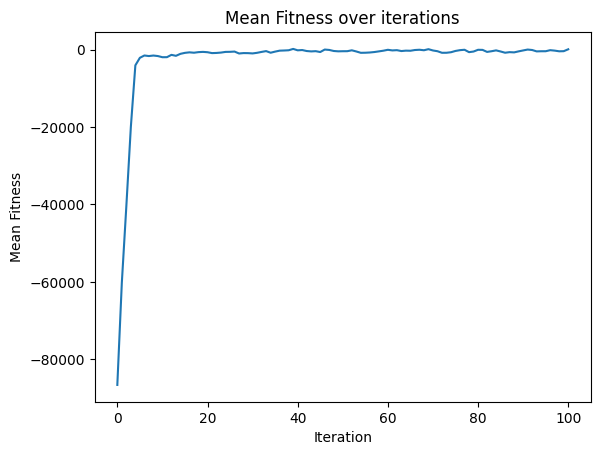

In [23]:
import numpy as np
import matplotlib.pyplot as plt

populationSize = 100
chromosomeSize = 100
seed = 42
maxWeight = 2000
#population = initializePopulation(populationSize, chromosomeSize, seed)
population = initializePopulationWithMaxWeight(populationSize, chromosomeSize, maxWeight, seed, 0.75)

# This genetic algorithm uses another elitism method
def geneticAlgorithm2(population: list[list], 
                     maxWeight: int, 
                     generations: int, 
                     crossoverRate: float, 
                     crossoverType: str, 
                     penaltyFactor: float = 1.5):
    
    meanFitness = []
    fitnessList = [calculateFitness(i, maxWeight, True, penaltyFactor) for i in population]
    mean = np.mean(fitnessList)
    meanFitness.append(mean)
    
    sortedPopulation = sortPopulation(population, maxWeight, True, penaltyFactor)
    bestIndividual = sortedPopulation[0]
    bestFitness = calculateFitness(bestIndividual, maxWeight, True, penaltyFactor)

    for i in range(generations):
        new_population = []
        while len(new_population) != len(population):
            
            firstIndividual = tournamentSelection(population, 2, maxWeight, penaltyFactor)
            secondIndividual = tournamentSelection(population, 2, maxWeight, penaltyFactor)
        
            #firstIndividual = rouletteWheelSelection(population, maxWeight, penaltyFactor)
            #secondIndividual = rouletteWheelSelection(population, maxWeight, penaltyFactor)
            
            #offsprings = singlePointCrossover(firstIndividual, secondIndividual)
            offsprings = performCrossover(firstIndividual, secondIndividual, crossoverType, crossoverRate, maxWeight, penaltyFactor)
            #offsprings = multiplePointCrossover(firstIndividual, secondIndividual)
            offsprings[0] = mutation(offsprings[0], len(offsprings[0]))
            offsprings[1] = mutation(offsprings[1], len(offsprings[1]))

            new_population.extend(offsprings)

        population = new_population
        sortedPopulation = sortPopulation(population, maxWeight, True, penaltyFactor)
        currentBestFitness = calculateFitness(sortedPopulation[0], maxWeight, True, penaltyFactor)
        if (currentBestFitness > bestFitness):
            bestIndividual = sortedPopulation[0]
            bestFitness = currentBestFitness
            
        #print(f"Generation {i}")
        #print(population)
        
        fitnessList = [calculateFitness(i, maxWeight, True, penaltyFactor) for i in population]
        mean = np.mean(fitnessList)
        meanFitness.append(mean)
        
    x = np.arange(0, generations + 1)
    plt.plot(x, meanFitness)
    plt.title("Mean Fitness over iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Fitness")
    
    return population, bestIndividual, bestFitness

generations = 100
penaltyFactor = 1.2
crossoverRate = 1
crossoverType = "uniform"
new, bestInd, bestFit = geneticAlgorithm2(population, maxWeight, generations,crossoverRate, crossoverType, penaltyFactor)


In [24]:
sortedNew = sortPopulation(new, maxWeight, True, penaltyFactor)
print(bestInd)
totalWeight = 0
totalProtein = 0
for i in range(len(bestInd)):
    if bestInd[i]:  
        protein = df.iloc[i]['Protein (g)']
        weight = df.iloc[i]['Calories']
        totalProtein += protein
        totalWeight += weight
print("Elitism")
print(f"Fitness {bestFit}, calorie {totalWeight}, protein {totalProtein}")

print("Actual")
for i in sortedNew:
    fitness = calculateFitness(i, maxWeight, True, penaltyFactor)
    totalWeight = 0
    totalProtein = 0
    
    for j in range(len(i)):
        if i[j]:  
            protein = df.iloc[j]['Protein (g)']
            weight = df.iloc[j]['Calories']
            totalProtein += protein
            totalWeight += weight

    print(f"Fitness {fitness}, calorie {totalWeight}, protein {totalProtein}")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Elitism
Fitness 1495.1, calorie 1843.0, protein 149.51
Actual
Fitness 1495.1, calorie 1843.0, protein 149.51
Fitness 1494.9306630717758, calorie 2011.0, protein 151.26999999999998
Fitness 1477.3999999999999, calorie 1803.0, protein 147.73999999999998
Fitness 1466.6, calorie 1968.0, protein 146.66
Fitness 1457.7999999999997, calorie 1962.0, protein 145.77999999999997
Fitness 1443.834119837586, calorie 2035.0, protein 151.51
Fitness 1427.2013516926938, calorie 2005.0, protein 143.41
Fitness 1426.7999999999997, calorie 1716.0, protein 142.67999999999998
Fitness 1377.3, calorie 1757.0, protein 137.73
Fitness 1374.4, calorie 1689.0, protein 137.44
Fitness 1369.0, calorie 1467.0, protein 136.9
Fi